<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI286 - Computación Científica II</h1>
    <h1> Tarea 3: PDE Inpaiting </h1> 
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
    <center>gagodoy@alumnos.inf.utfsm.cl </center>
    <center>Guillermo Godoy - 201391001-7 </center>
<center>Diciembre 2019 - v1.0 </center>
</p>

---

In [47]:
import numpy as np
import scipy as sp
import imutils
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import math

## Contexto

_Inpaiting_ es el proceso mediante el cual se busca mejorar la calidad o restaurar una imagen que ha sufrido alteraciones o deterioros. En nuestro caso, el objetivo será reparar una imagen a la que le falta un conjunto de bits.

<img src="example.png" style="float:center;height:200px">

Existen muchas técnicas para poder reconstruir los bits faltantes, y seguramente a usted ya se le habrán ocurrido algunas maneras utilizando tecnicas vistas en Computación Científica (interpolación polinomial, splines) o en otras asignaturas. En este laboratorio le presentaremos una nueva técnica basada en ecuaciones diferenciales parciales.

La ecuación de calor es una PDE que modela como la temperatura de un cuerpo sólido se comporta a través del tiempo. Esta es una PDE del tipo parabólica y tiene la siguiente forma:

\begin{equation}
    u_t = \sigma\,\Delta u,
\end{equation}
donde $\sigma$ es un coeficiente de difusión.
Esta ecuación también se conoce como ecuación de difusión, pues describe como un valor (en este caso temperatura) se disipa. Consideremos la siguiente variación:

$$
    u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy},
$$

para "disipar" los valores de la imagen hacia los bits faltantes, donde $\sigma_x$ y $\sigma_y$ son valores reales. Un ejemplo del efecto de disipación sería el de la siguiente imagen:

<img src="dif.png" style="float:center;height:200px"><br>

Para definir el problema, debemos relacionar la EDP con la imagen y determinar cuales serían las condiciones iniciales y de borde apropiadas.
Consideremos que la imagen $I$ posee un conjunto de *missing values* en los pixeles $(c_x, c_y)$, de ancho $W$ y largo $H$.
Como se puede desprender de la imagen de ejemplo, las condiciones de borde corresponden a los pixeles conocidos que bordean al conjunto de *missing values* de la imagen. Esto significa que el dominio del problema corresponde a los *missing values* y los pixeles que rodean a este. Matemáticamente, podemos definir como dominio de la EDP  el conjunto $\Omega = [0, 1]^2$. La malla a utilizar para resolver numéricamente la EDP debe contener $W+2$ puntos en el eje $x$ (largo del dominio de *missing values* más dos puntos correspondientes a los pixeles conocidos) y $H+2$ puntos en el eje $y$. Sea $(x_i, y_j)$ un par en el borde del dominio, definiremos las condiciones de borde como

$$
    u(x_i, y_j, t) = I_{c_x+i, c_y+j}, \forall t > 0,
$$

donde $I_{n,m}$ corresponde al pixel en la posición $(n, m)$.

Para la condición inicial, idealmente necesitaríamos la imagen real (sin *missing values*). Sin embargo, esto es lo que deseamos encontrar. Sabemos que los pixeles al rededor de los *missing values* serán fijos (vienen de la imagen), por lo que podemos establecer cualquier valor arbitrario como valor inicial. Si consideramos que los pixeles son valores entre $0$ y $1$, entonces la condición inicial se define como:

$$
    u(x_i, y_j, 0) = 
    \begin{cases}
        I_{c_x+i, c_y+j}\quad&, \text{si }$(x_i, y_j)$ \text{corresponde al borde}, \\
        \alpha\quad&, \text{si }$(x_i, y_j)$ \text{corresponde a un punto interior},
    \end{cases}
$$
con $\alpha \in [0, 1]$.

Con esto tenemos los los elementos necesarios para aplicar *inpainting*! Un detalle importante es que la imagen es bidimensional, por lo que la EDP de calor tendrá dos dimensiones espaciales. 

## Sección 1 (60 puntos)

1. Discretice la ecuación de calor mediante Diferencias Finitas. Para el tiempo, utilice un esquema explícito.

La ecuación de calor definida como $u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy} $. Se puede discretizarla mediante diferencias finitas usando las siguientes aproximaciones:

$$
\begin{align}
u_t (x,y,t) &\approx \frac{u(x,y,t+\Delta t)-u(x,y,t)}{\Delta t}\\
u_{xx} (x,y,t) &\approx \frac{u(x+\Delta x,y,t) - 2u(x,y,t) + u(x-\Delta x,y,t)}{\Delta x^2}\\
u_{yy} (x,y,t) &\approx \frac{u(x,y+\Delta y,t) - 2u(x,y,t) + u(x,y-\Delta y,t)}{\Delta y^2}
\end{align}
$$

Como se menciona anteriormente en el enunciado, los *missing values* se encuentran en un rectángulo de $W*H$ con el conjunto $\Omega = [0, 1]^2$ como dominio, por lo que la grilla equiespaciada queda dividida en $(W+2)\times(H+2)\times(N_t + 1)$ puntos. Así, se tiene que los valores discretos son:

$$
\begin{align}
x_i &= x_0 + i\Delta x, i \in \{0,1,...,W+1\}\\
y_j &= y_0 + j\Delta x, j \in \{0,1,...,H+1\}\\
t_n &= t_0 + n\Delta t = n\Delta t, n \in \{0,1,...,N_t\}
\end{align}
$$

Con:
$$
\begin{align}
\Delta x &= \frac{1}{W+1}\\
\Delta y &= \frac{1}{H+1}\\
\Delta t &= cualquiera
\end{align}
$$

Para definir una sola incógnita se aproxima se la siguiente forma:

<center> $u(x_{i},y_{j},t_{n}) \approx w_{i,j,n}$</center>

Lo anterior queda:

$$
\frac{w_{i,j,n+1}-w_{i,j,n}}{\Delta t} = \sigma_x \frac{w_{i+1,j,n}-2w_{i,j,n}+w_{i-1,j,n}}{\Delta x^2} + \sigma_y \frac{w_{i,j+1,n}-2w_{i,j,n}+w_{i,j-1,n}}{\Delta y^2}
$$

Despejando $w_{i,j,n+1}$ y reagrupando términos, se tiene:

<center><bold>$w_{i,j,n+1} = \alpha (w_{i+1,j,n} + w_{i-1,k,n}) + \beta (w_{i,j+1,n} + w_{i,j-1,n}) + \gamma w_{i,j,n}$</bold></center>

Con:
$$
\begin{align}
\alpha  &=\frac{\Delta t\sigma_x}{\Delta x^2}\\
\beta   &=\frac{\Delta t\sigma_y}{\Delta y^2}\\
\gamma  &=\left(1-2A-2B\right)
\end{align}
$$


2. Implemente un algoritmo que encuentre el sector de la imagen que posee los *missing values*, donde la imagen es representada como una matriz de *numpy*. Los *missing values* serán identificados mediante el valor `NaN`. Su algoritmo debe retornar la posición en donde empiezan los *missing values* (coordenada superior izquierda), y el ancho y largo del sector de *missing values*. Considere que los agujeros siempre tendrán forma rectangular.

In [314]:
'''
Input:
image - (array) matrix form of image
Output:
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
'''
def findHole(image):
    start=(0,0)
    width=0
    lenght=0
    widthTotal=len(image)
    print(widthTotal)
    lengthTotal=len(image[0])
    print(lengthTotal)
    for i in range(widthTotal):
        for k in range(lengthTotal):
            if np.isnan(image[i][k]):
                if start==(0,0):
                    start=(k,i)
                else:
                    lenght=i-start[1]+1
                    width=k-start[0]+1
    print(start)
    print(width)
    print(lenght)
    return start, width, lenght

Puede utilizar la siguiente función para cargar las imágenes con *missing values* (valores `NaN`):

In [224]:
# For npy files
def read_image_with_nan(path):
    return np.load(path, allow_pickle=True)

y la siguiente función para cargar imágenes comunes:

In [282]:
# For PNG files
def read_image(path):
    return imread(path, format='png')

In [283]:
img_nan = read_image_with_nan('wavenan.npy')
img = read_image('wave.png')

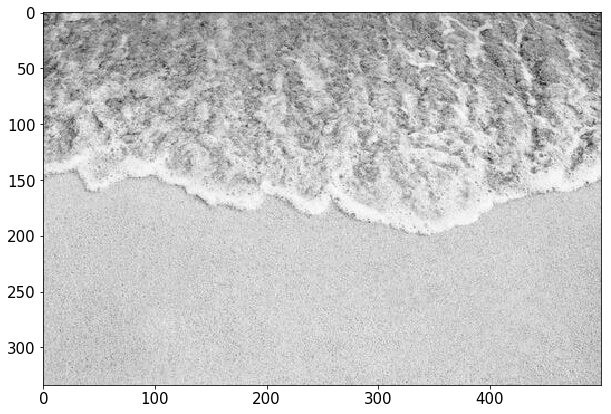

In [284]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

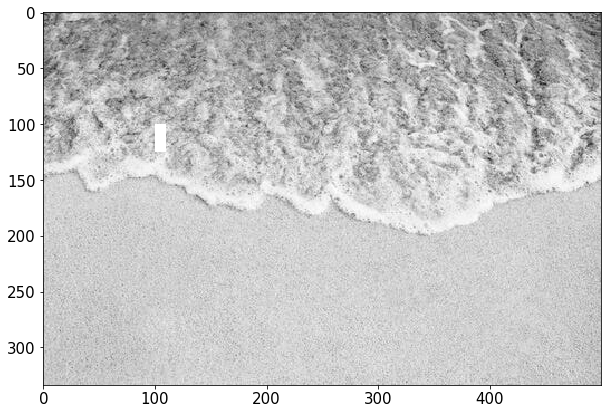

In [285]:
plt.figure(figsize=(10, 10))
plt.imshow(img_nan, cmap='gray')

3. Notar que la ecuación de calor está definida para todo $t > 0$. Sin embargo, sabemos que al ser difusiva tendrá un estado estacionario. Implemente un algoritmo que construya los pixeles faltantes de una imagen mediante el método planteado. Su algoritmo debe recibir la imagen a reconstruir, la ubicación de los pixeles faltantes, el valor $\alpha$ de inicio para la condición inicial, el coeficiente de difusión $\sigma$ y el *timestep*. Su algoritmo debe iterar hasta que se llegue a un estado aproximadamente estacionario. Indique como estimará si se ha llegado o no a dicho estado y justifique su elección.

In [350]:
'''
Input:
image - (array) matrix form of image
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
alpha - (float) A fixed value for initial condition
sigmax - (float) Fist difussion coefficient
sigmay - (float) Second difussion coefficient
dt - (float) time step
Output:
newImage - (array) matrix form of reconstructed image
'''
def fillHole(image, start, width, lenght, alpha, sigmax, sigmay, dt):
    newImage=np.copy(image)
    dx = 1/(width+1)
    dy = 1/(lenght+1)
    a = sigmax*dt/dx**2
    b = sigmay*dt/dy**2
    if a+b>0.5:
        print('El método es inestable!')
        return newImage
    A = np.zeros([(width+2)*(lenght+2), (width+2)*(lenght+2)])
    B = np.zeros([(width+2)*(lenght+2),1])
    bordes = B.copy()
    
    for i in range(start[0],start[0]+lenght):
        for k in range(start[1],start[1]+width):
            newImage[i][k] = alpha
            
    for i in range(width+2):
        for k in range(lenght+2):
            j = k+i*(lenght+2)
            B[j] = newImage[start[1]-1+k][start[0]-1+i]
            if i == 0 or i == width+1 or k == 0 or k == lenght+1:
                bordes[j] = newImage[start[1]-1+k][start[0]-1+i]

    for j in range((width+2)*(lenght+2)):
        if(bordes[j] == 0):
            i = j%(lenght+2)
            k = int(j/(lenght+2))
            A[j][i+1+(k*(lenght+2))] = b 
            A[j][i-1+(k*(lenght+2))] = b 
            A[j][i+(k+1)*(lenght+2)] = a 
            A[j][i+(k-1)*(lenght+2)] = a 
            A[j][j] = 1 - 2*sigmax*dt/dx**2 - 2*sigmay*dt/dy**2
    
    i = 0
    tolx = 1e-06
    toly = 1e-09
    while True:
        auxB = B.copy()
        B = np.dot(A,B) + bordes
        i+=1
        if np.allclose(auxB, B, tolx, toly):
            print("Itera ", i)
            break
    k = 0   
    for i in range(start[0],start[0]+lenght):
        for j in range(start[1],start[1]+width):
            newImage[i][j] = B[k]
            k+=1 
    return newImage



4. Evalúe su implementación con los valores de $\sigma_x = \sigma_y = 1$ y $\alpha = 0$. Comente en función de los resultados obtenidos.

334
500
(100, 100)
10
25
Itera  52


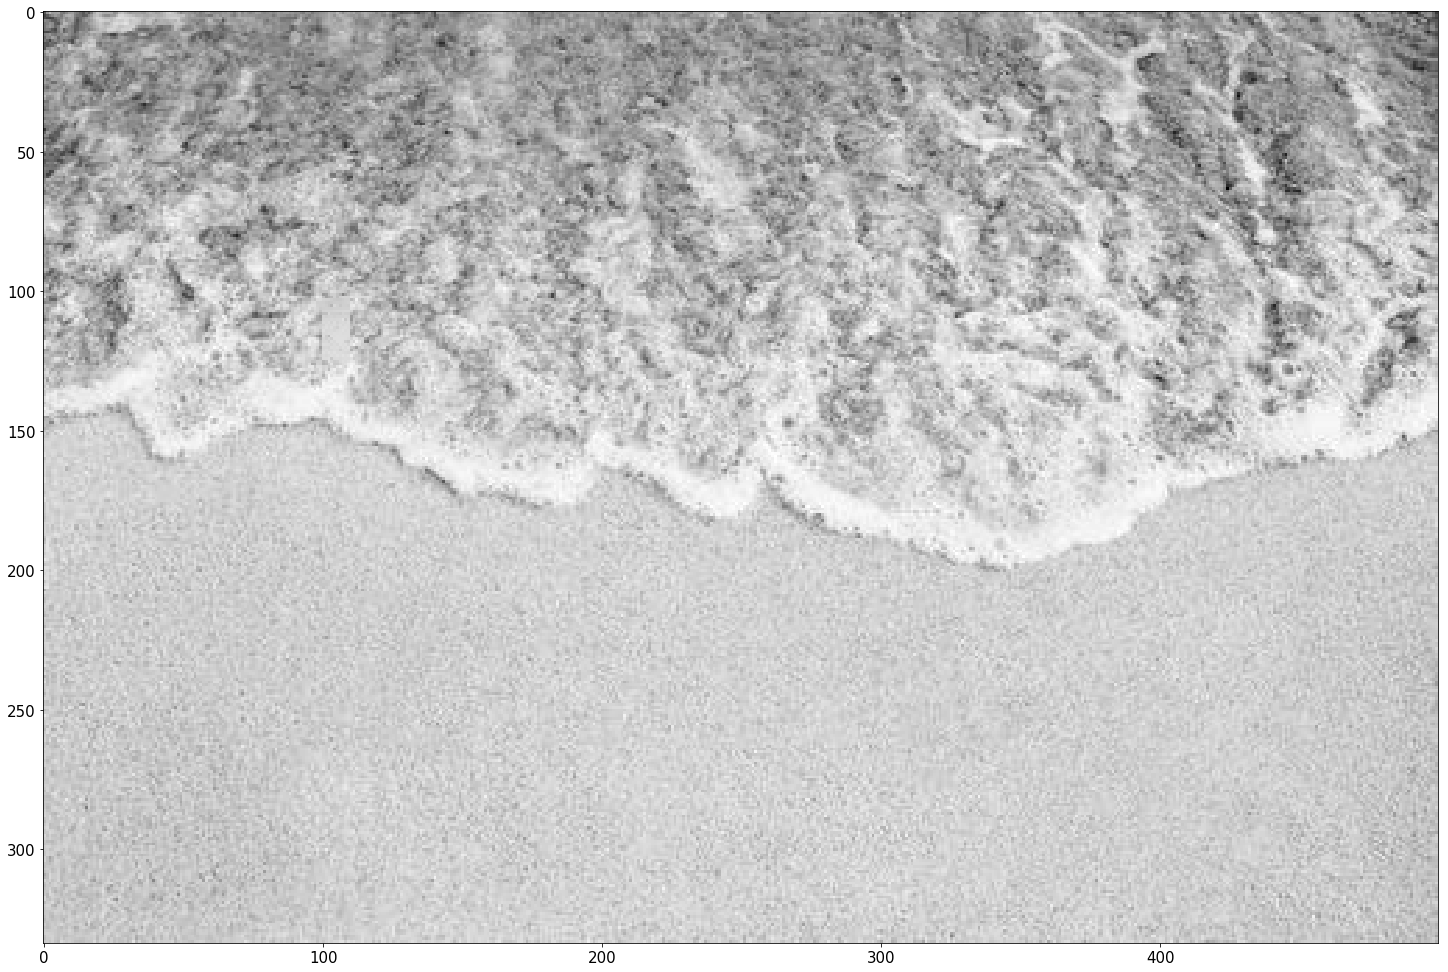

In [351]:

start,width,lenght=findHole(img_nan)


im1 = fillHole(img_nan,start, width, lenght, 0, 1, 1, 0.0001)

plt.figure(figsize=(25, 25))
plt.imshow(img_new, cmap='gray')

Se logra obtener una imagen con una mejora en el sector de nan, obteniendo colores acorde a la imagen en general, pero no se logra generar de modo real obteniendo una tramo difuso con grises donde no deberian estar.

## Sección 2 (60 puntos)

1. Aplique su algoritmo de la Sección 1 para distintos valores de $\sigma_x$, $\sigma_y$, $\alpha$ y *timestep*. Concluya al respecto. Recuerde considerar la estabilidad en la variación de los valores de $\sigma_x$ y $\sigma_y$.

Itera  30360
Itera  3972
Itera  19343
Itera  16296
Itera  19953
Itera  49279


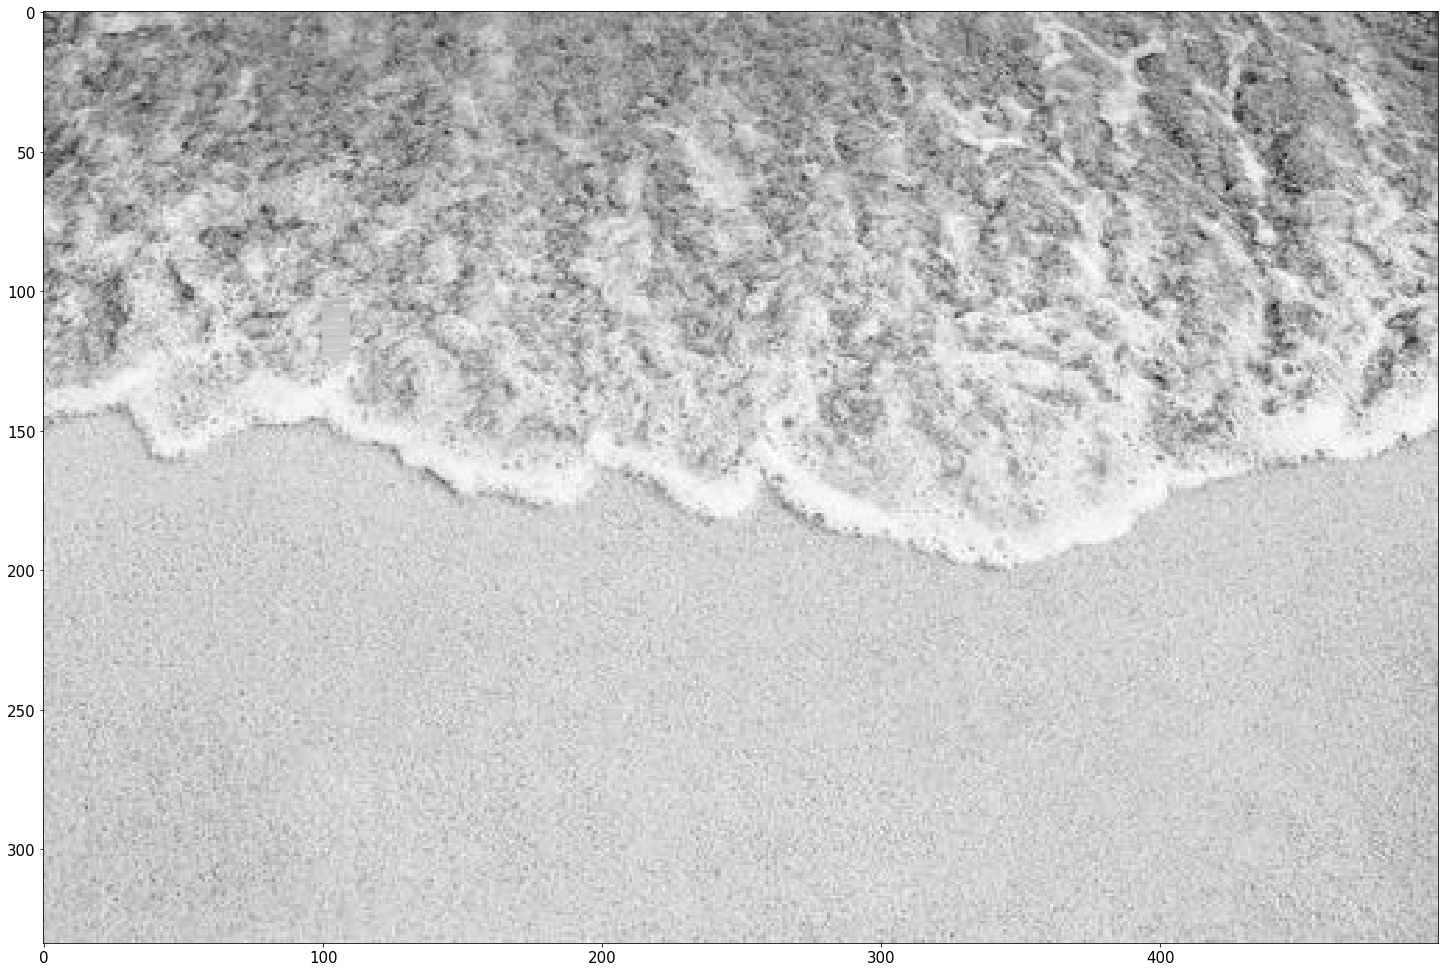

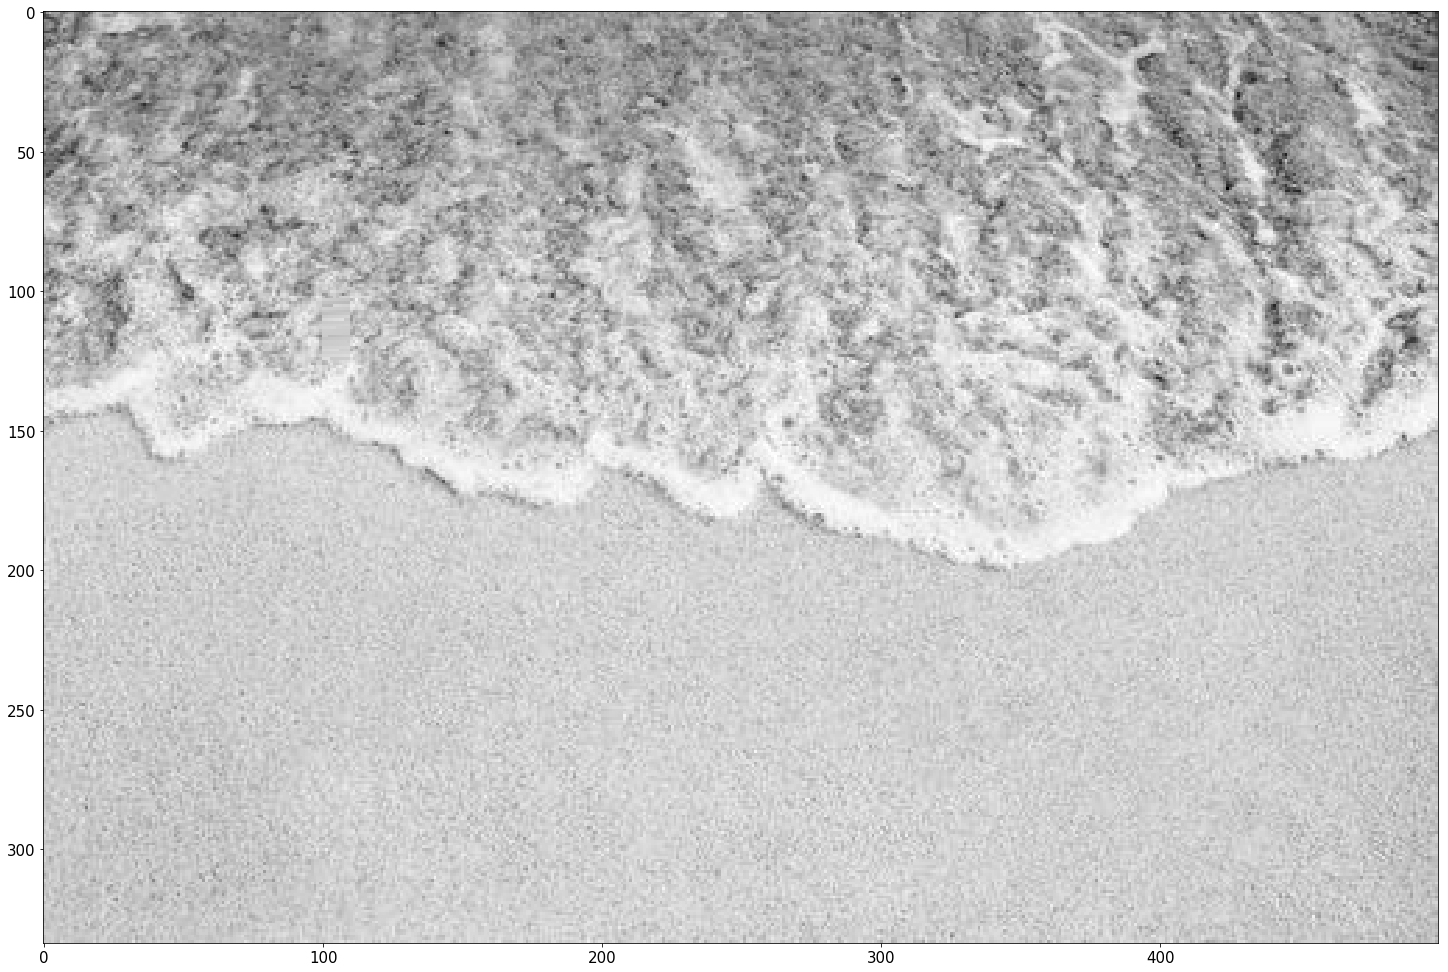

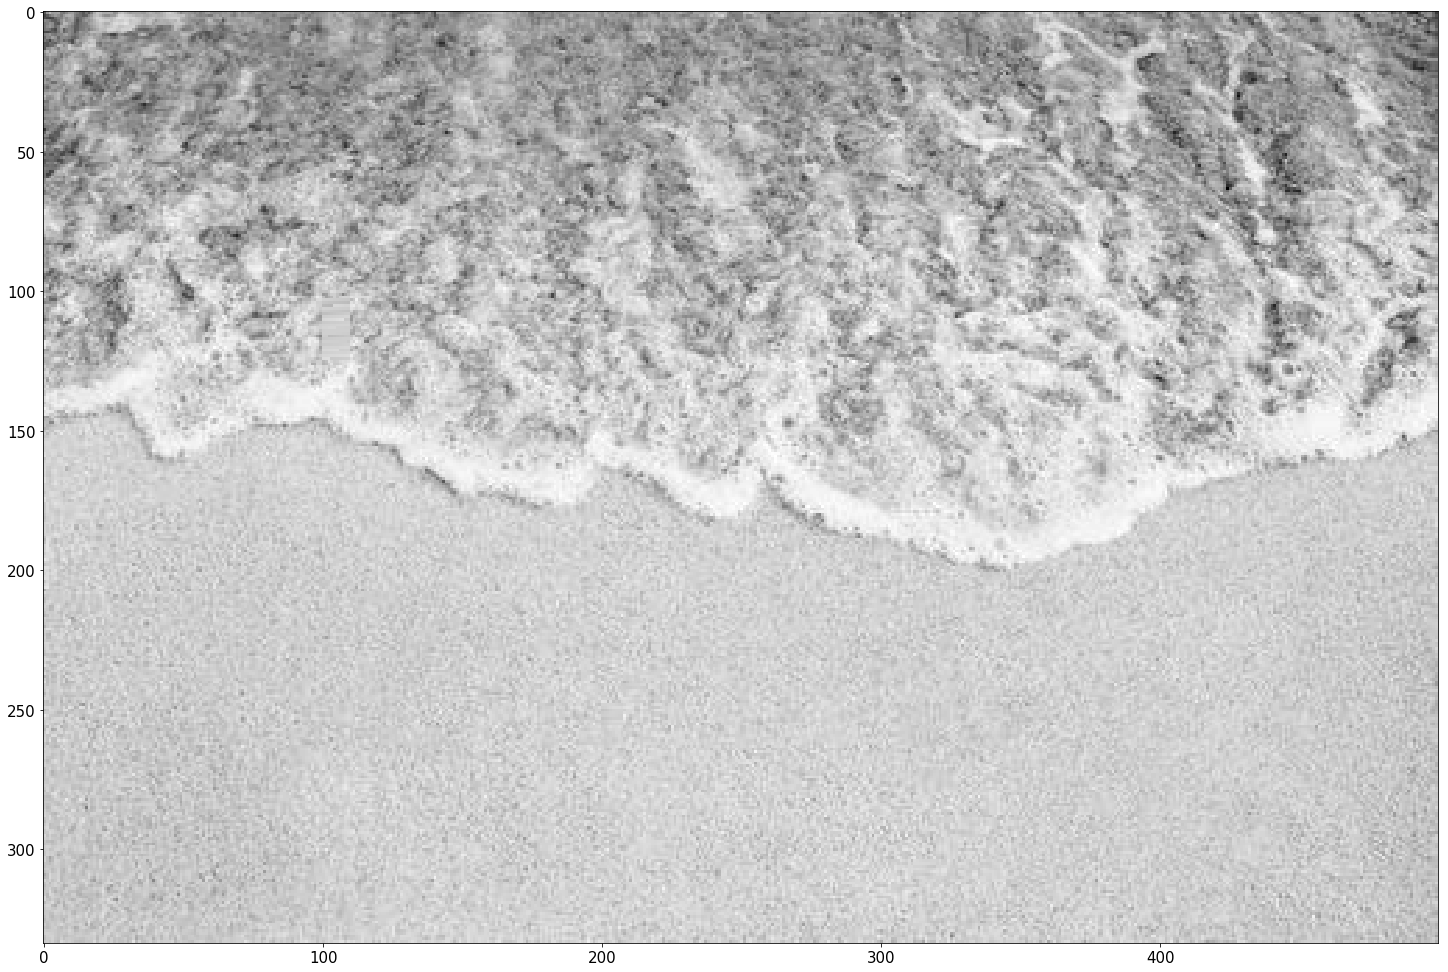

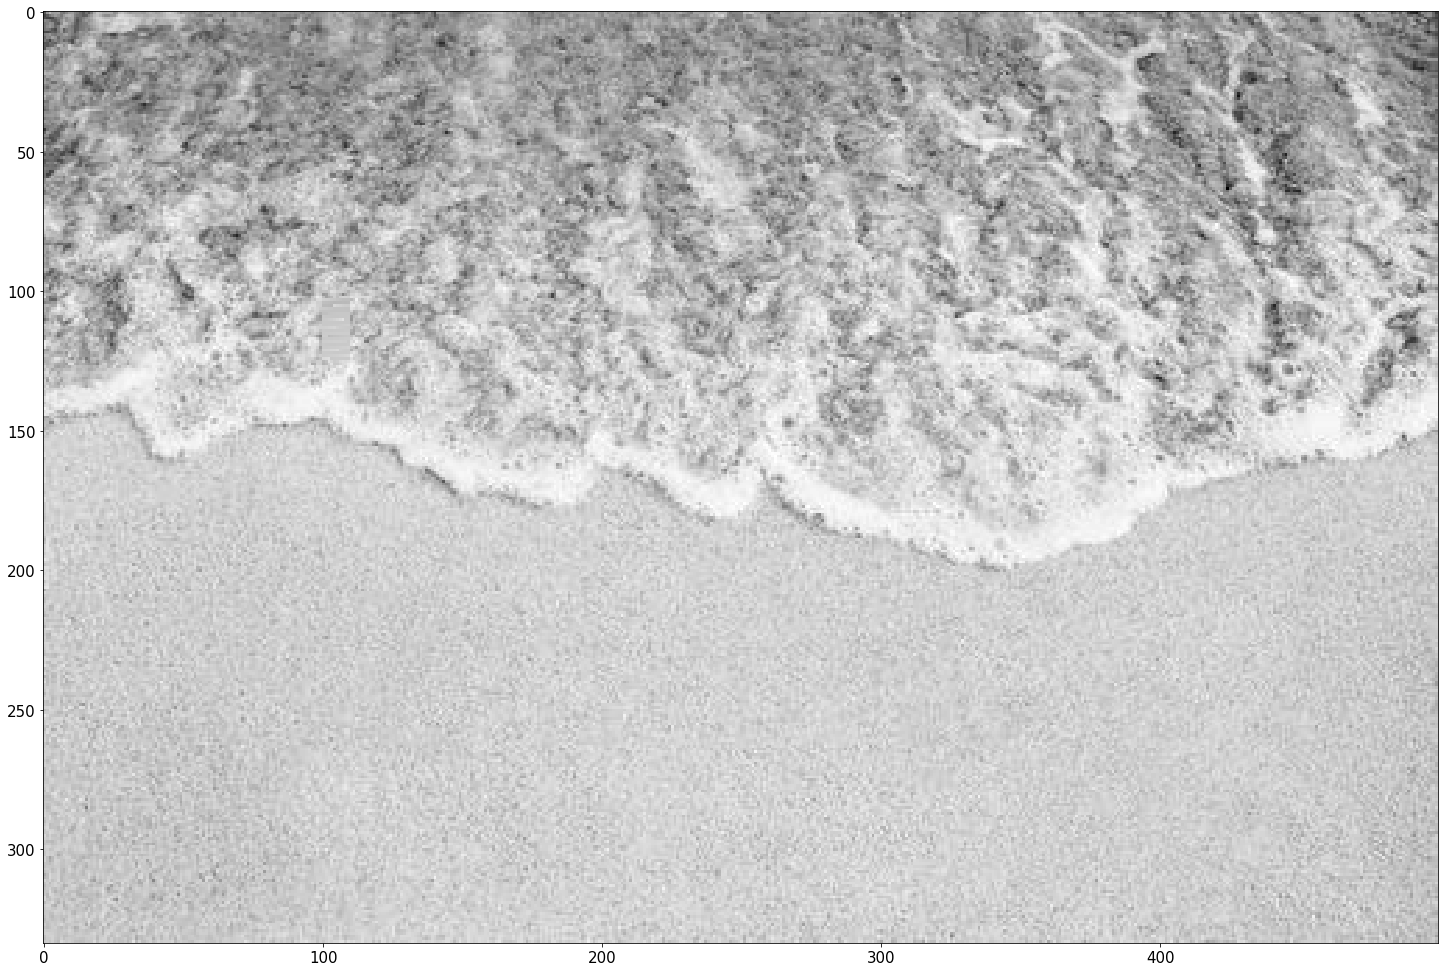

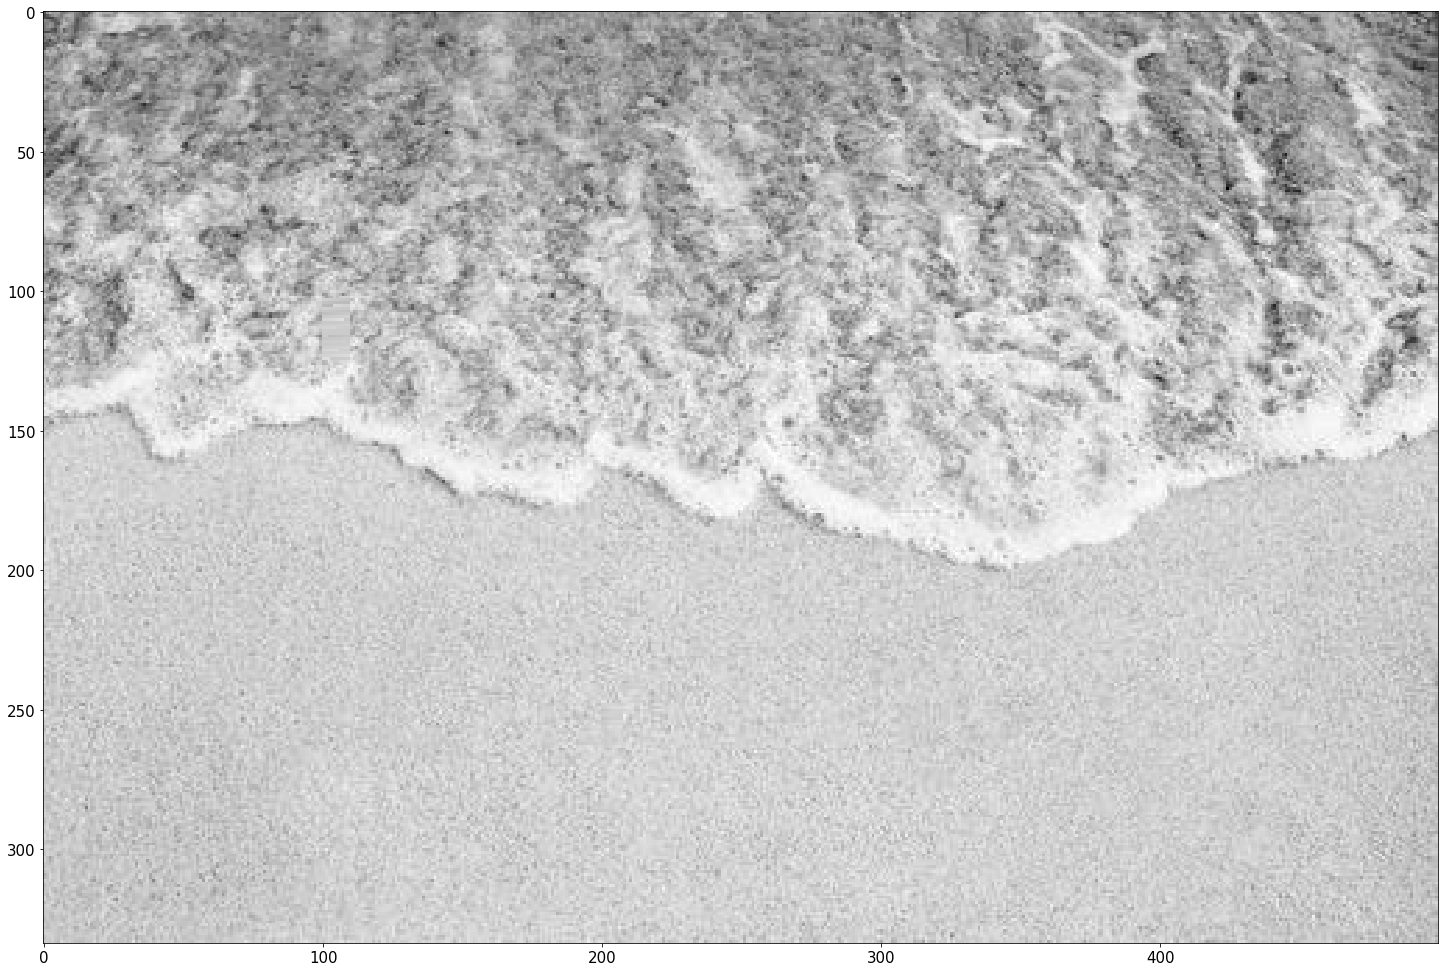

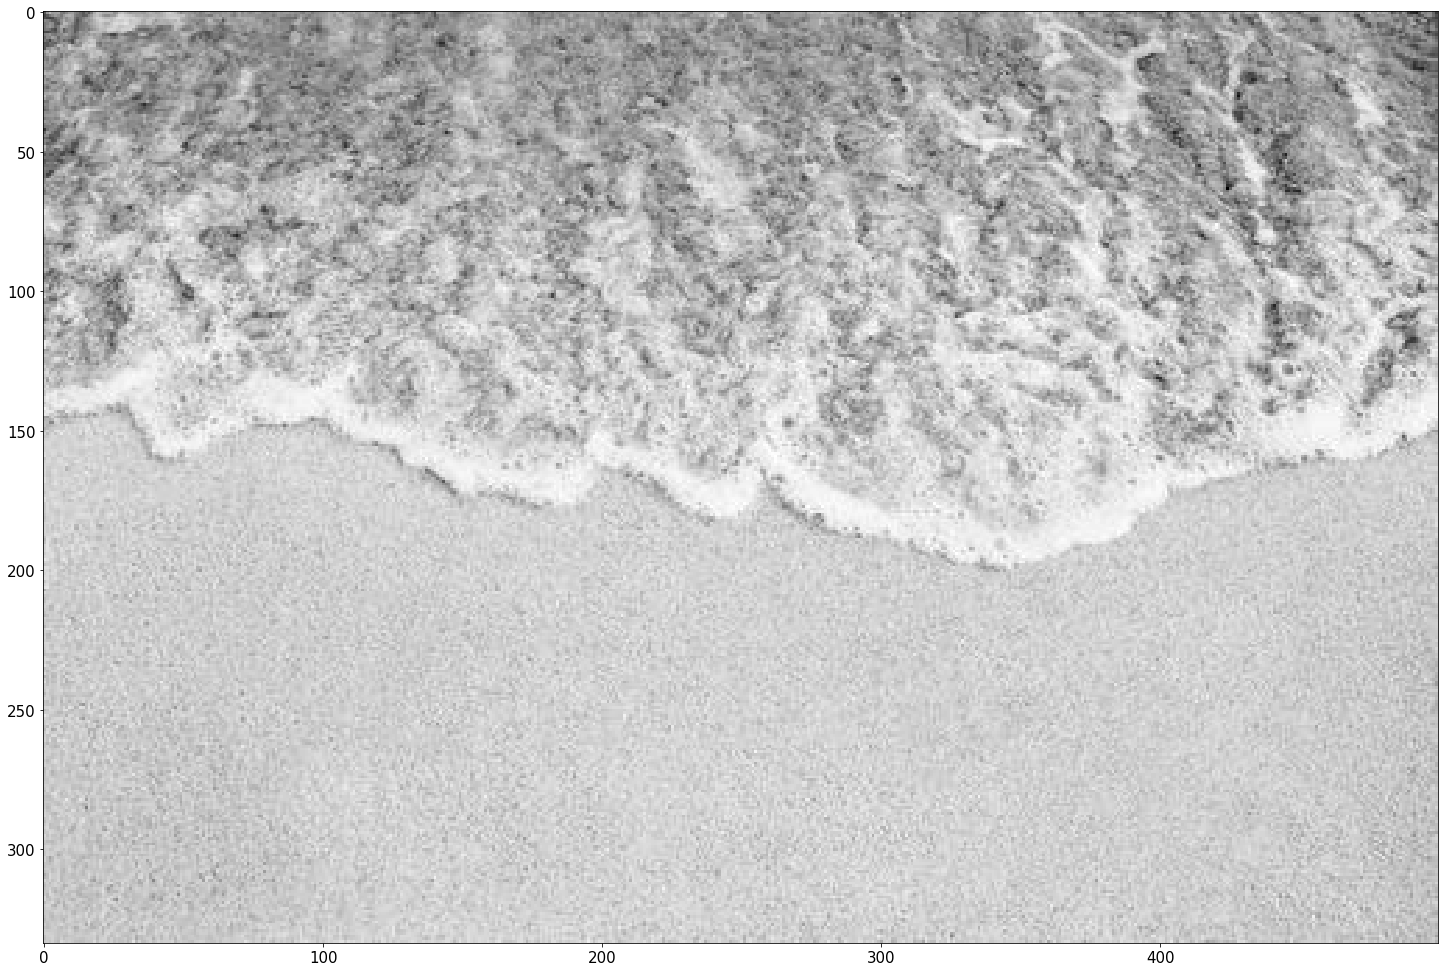

In [333]:
im2 = fillHole(img_nan,start, width, lenght, 0.2, 0.5, 1.3, 0.00001)
im3 = fillHole(img_nan,start, width, lenght, 0.003, 0.03, 2.0, 0.0001)
im4 = fillHole(img_nan,start, width, lenght, 0.9, 0.03, 0.9, 0.00001)
im5 = fillHole(img_nan,start, width, lenght, 0.02, 0.1, 0.3, 0.0001)
im6 = fillHole(img_nan,start, width, lenght, 0.02, 0.01, 0.3, 0.0001)

im7 = fillHole(img_nan,start, width, lenght, 0, 1, 0.0001, 0.00001)


plt.figure(figsize=(25, 25))
plt.imshow(im2, cmap='gray')
plt.figure(figsize=(25, 25))
plt.imshow(im3, cmap='gray')
plt.figure(figsize=(25, 25))
plt.imshow(im4, cmap='gray')
plt.figure(figsize=(25, 25))
plt.imshow(im5, cmap='gray')
plt.figure(figsize=(25, 25))
plt.imshow(im6, cmap='gray')

plt.figure(figsize=(25, 25))
plt.imshow(im7, cmap='gray')

2. Utilice la *Normal de Frobenius* para medir el error entre la imagen con *inpainting* y la imagen original. Mida el error para distintos valores de $\sigma_x$, $\sigma_y$, $\alpha$ y *timestep*. Concluya al respecto.

In [334]:
print("Error en imagen 1:",np.linalg.norm(img-im1, ord="fro"))
print("Error en imagen 2:",np.linalg.norm(img-im2, ord="fro"))
print("Error en imagen 3:",np.linalg.norm(img-im3, ord="fro"))
print("Error en imagen 4:",np.linalg.norm(img-im4, ord="fro"))
print("Error en imagen 5:",np.linalg.norm(img-im5, ord="fro"))
print("Error en imagen 6:",np.linalg.norm(img-im6, ord="fro"))
print("Error en imagen 7:",np.linalg.norm(img-im7, ord="fro"))

Error en imagen 1: 1.3010834
Error en imagen 2: 1.3323327
Error en imagen 3: 1.3985442
Error en imagen 4: 1.4348427
Error en imagen 5: 1.3484099
Error en imagen 6: 1.3847896
Error en imagen 7: 1.3738184


En la imagen 7, me queda una imagen más cercana a la real segun mi apreciación, pero la normal de Frobenius, me sigue considerando como un error grande, por lo cual no me convence utilizar esta normal para revisar las imagenes

3. Proponga un algoritmo que permita *optimizar* el valor de $\sigma_x$ y $\sigma_y$ respecto a la norma de Frobenius. Para esta sección elija un valor de $\alpha$ fijo, en función de los experimentos realizados en las preguntas 1 y 2 de la sección 2. Su algoritmo debe *optimizar* utilizando las imágenes dentro de la carpeta `train_images`. Una vez obtenidos los valores de $\sigma_x$ y $\sigma_y$, evalúe el desempeño con las imágenes de `train_images`. Comente y concluya en función de sus resultados.

In [352]:
def fillHole2(image, start, width, lenght, alpha, sigmax, sigmay, dt):
    newImage=np.copy(image)
    dx = 1/(width+1)
    dy = 1/(lenght+1)
    a = sigmax*dt/dx**2
    b = sigmay*dt/dy**2
    if a+b>0.5:
        print('El método es inestable!')
        return newImage
    A = np.zeros([(width+2)*(lenght+2), (width+2)*(lenght+2)])
    B = np.zeros([(width+2)*(lenght+2),1])
    bordes = B.copy()
    
    for i in range(start[0],start[0]+lenght):
        for k in range(start[1],start[1]+width):
            newImage[i][k] = alpha
            
    for i in range(width+2):
        for k in range(lenght+2):
            j = k+i*(lenght+2)
            B[j] = newImage[start[1]-1+k][start[0]-1+i]
            if i == 0 or i == width+1 or k == 0 or k == lenght+1:
                bordes[j] = newImage[start[1]-1+k][start[0]-1+i]

    for j in range((width+2)*(lenght+2)):
        if(bordes[j] == 0):
            i = j%(lenght+2)
            k = int(j/(lenght+2))
            A[j][i+1+(k*(lenght+2))] = b 
            A[j][i-1+(k*(lenght+2))] = b 
            A[j][i+(k+1)*(lenght+2)] = a 
            A[j][i+(k-1)*(lenght+2)] = a 
            A[j][j] = 1 - 2*sigmax*dt/dx**2 - 2*sigmay*dt/dy**2
    
    i = 0
    tolx = 1e-01
    toly = 1e-02
    while True:
        auxB = B.copy()
        B = np.dot(A,B) + bordes
        i+=1
        if np.allclose(auxB, B, tolx, toly):
            print("Itera ", i)
            break
    k = 0   
    for i in range(start[0],start[0]+lenght):
        for j in range(start[1],start[1]+width):
            newImage[i][j] = B[k]
            k+=1 
    return newImage


def train_images(alpha, sigmax, sigmay, dt):
    Rimg_nan1 = read_image_with_nan('train_images/im1.npy')
    Rimg1 = read_image('train_images/im1.png')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg1, cmap='gray')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg_nan1, cmap='gray')
    
    Rimg_nan2 = read_image_with_nan('train_images/im2.npy')
    Rimg2 = read_image('train_images/im2.png')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg2, cmap='gray')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg_nan2, cmap='gray')
    
    
    Rimg_nan3 = read_image_with_nan('train_images/im3.npy')
    Rimg3 = read_image('train_images/im3.png')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg3, cmap='gray')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg_nan3, cmap='gray')
    
    Rimg_nan4 = read_image_with_nan('train_images/im4.npy')
    Rimg4 = read_image('train_images/im4.png')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg4, cmap='gray')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg_nan4, cmap='gray')
    
    Rimg_nan5 = read_image_with_nan('train_images/im5.npy')
    Rimg5 = read_image('train_images/im5.png')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg5, cmap='gray')
    #plt.figure(figsize=(10, 10))
    #plt.imshow(Rimg_nan5, cmap='gray')
    
    
    
    if (len(Rimg_nan1.shape)>2):
        Rimg_nan1=Rimg_nan1[:,:,0]
    start1,width1,lenght1=findHole(Rimg_nan1)
    
    if (len(Rimg_nan2.shape)>2):
        Rimg_nan2=Rimg_nan2[:,:,0]
    start2,width2,lenght2=findHole(Rimg_nan2)
    
    if (len(Rimg_nan3.shape)>2):
        Rimg_nan3=Rimg_nan3[:,:,0]
    start3,width3,lenght3=findHole(Rimg_nan3)
    
    if (len(Rimg_nan4.shape)>2):
        Rimg_nan4=Rimg_nan4[:,:,0]
    start4,width4,lenght4=findHole(Rimg_nan4)
    
    if (len(Rimg_nan5.shape)>2):
        Rimg_nan5=Rimg_nan5[:,:,0]
    start5,width5,lenght5=findHole(Rimg_nan5)
    sw=0
    peso=0.1
    ant=0
    while True:
        print("Generando imagen1")
        im1 = fillHole2(Rimg_nan1,start1, width1, lenght1, alpha, sigmax, sigmay, dt)
        print("Generando imagen2")
        im2 = fillHole2(Rimg_nan2,start2, width2, lenght2, alpha, sigmax, sigmay, dt)
        print("Generando imagen3")
        im3 = fillHole2(Rimg_nan3,start3, width3, lenght3, alpha, sigmax, sigmay, dt)
        print("Generando imagen4")
        im4 = fillHole2(Rimg_nan4,start4, width4, lenght4, alpha, sigmax, sigmay, dt)
        print("Generando imagen5")
        im5 = fillHole2(Rimg_nan5,start5, width5, lenght5, alpha, sigmax, sigmay, dt)
        print("Generando imagen6")
        r1=np.linalg.norm(Rimg1-im1, ord="fro")
        r2=np.linalg.norm(Rimg2-im2, ord="fro")
        r3=np.linalg.norm(Rimg3-im3, ord="fro")
        r4=np.linalg.norm(Rimg4-im4, ord="fro")
        r5=np.linalg.norm(Rimg5-im5, ord="fro")
        prom=(r1+r2+r3+r4+r5)/5
        print("Promedio",prom)
        
        if (prom<0.1):
            break
        elif(sw==0):
            sw=1
            ant=prom
            sigmax+=peso
            sigmay+=peso
        elif(sw==1):
            if (ant<prom):
                sw=2
                ant=prom
                sigmax+=peso
                sigmay-=peso
            else:
                ant=prom
                sigmax+=peso
                sigmay+=peso
        elif(sw==2):
            if (ant<prom):
                sw=3
                ant=prom
                sigmax-=peso
                sigmay+=peso
            else:
                ant=prom
                sigmax+=peso
                sigmay-=peso
        elif(sw==3):
            if (ant<prom):
                sw=4
                ant=prom
                sigmax-=peso
                sigmay-=peso
            else:
                ant=prom
                sigmax-=peso
                sigmay+=peso
        elif(sw==4):
            if (ant>prom):
                sw=5
                ant=prom
                sigmax+=peso
                sigmay+=peso
            else:
                ant=prom
                sigmax-=peso
                sigmay-=peso
        elif(sw==5):
            if (ant>prom):
                sw=1
                ant=prom
                peso=peso+peso
                sigmax+=peso
                sigmay+=peso
            else:
                ant=prom
                sigmax-=peso
                sigmay-=peso
    print(sigmax)
    print(sigmay)
    return sigmax,sigmay

train_images(0,1,1,0.0001)


427
640
(250, 110)
25
55
637
991
(250, 350)
50
30
375
600
(80, 100)
10
30
512
512
(180, 200)
20
25
732
1360
(400, 300)
60
20
Generando imagen1


KeyboardInterrupt: 

## Sección 3 (50 puntos)

1. Discretice la ecuación de calor para usarla en este problema, usando un esquema implícito. Incluya una imagen de los stencil explícitos e implícitos y comparelos.

R:

Usando un esquema explícito
$$
\begin{align}
u_t (x,y,t) &\approx \frac{u(x,y,t)-u(x,y,t-\Delta t)}{\Delta t}\\
u_{xx} (x,y,t) &\approx \frac{u(x+\Delta x,y,t) - 2u(x,y,t) + u(x-\Delta x,y,t)}{\Delta x^2}\\
u_{yy} (x,y,t) &\approx \frac{u(x,y+\Delta y,t) - 2u(x,y,t) + u(x,y-\Delta y,t)}{\Delta y^2}
\end{align}
$$
Con:
$$
\begin{align}
N_x &= W+1\\
N_y &= H +1
\end{align}
$$

La discretización para la ecuación de calor queda como:

$$
\frac{u(x,y,t)-u(x,y,t -\Delta t)}{\Delta t} = \sigma_x\frac{u(x+\Delta x,y,t) - 2u(x,y,t) + u(x-\Delta x,y,t)}{\Delta x^2} + \sigma_y\frac{u(x,y+\Delta y,t) - 2u(x,y,t) + u(x,y-\Delta y,t)}{\Delta y^2}
$$

Al tomar $w_{i,j,n} \approx u(x_i,y_j,t_n)$:

$$
\frac{w_{i,j,n}-w_{i,j,n-1}}{\Delta t} = \sigma_x \frac{w_{i+1,j,n}-2w_{i,j,n}+w_{i-1,j,n}}{\Delta x^2} + \sigma_y \frac{w_{i,j+1,n}-2w_{i,j,n}+w_{i,j-1,n}}{\Delta y^2}
$$

Se puede cambiar la notación anterior a una forma equivalente para $n \geq 0$, quedando de la siguiente manera:

$$
\frac{w_{i,j,n+1}-w_{i,j,n}}{\Delta t} = \sigma_x \frac{w_{i+1,j,n+1}-2w_{i,j,n+1}+w_{i-1,j,n+1}}{\Delta x^2} + \sigma_y \frac{w_{i,j+1,n+1}-2w_{i,j,n+1}+w_{i,j-1,n+1}}{\Delta y^2}
$$

Al agrupar valores conocidos a la derecha y las incógnitas a la izquierda se obtiene:

$$
w_{i,j,n+1} - \frac{\sigma_x\Delta t}{\Delta x^2}\left(w_{i+1,j,n+1}-2w_{i,j,n+1}+w_{i-1,j,n+1}\right) - \frac{\sigma_y\Delta t }{\Delta y^2}\left(w_{i,j+1,n+1}-2w_{i,j,n+1}+w_{i,j-1,n+1}\right) = w_{i,j,n}
$$
Con:
$$
\begin{align}
\alpha  &=\frac{\sigma_x\Delta t}{\Delta x^2}\\
\beta   &=\frac{\sigma_y\Delta t }{\Delta y^2}\\
\gamma  &=\left(1+2A+2B\right)
\end{align}
$$


La ecuación queda de la siguiente forma:

$$
\gamma w_{i,j,n+1} - \alpha\left(w_{i+1,j,n+1}+w_{i-1,j,n+1}\right) - \beta\left(w_{i,j+1,n+1}+w_{i,j-1,n+1}\right) = w_{i,j,n}
$$

Text(0.5, 0.92, 'Esquema Implícito')

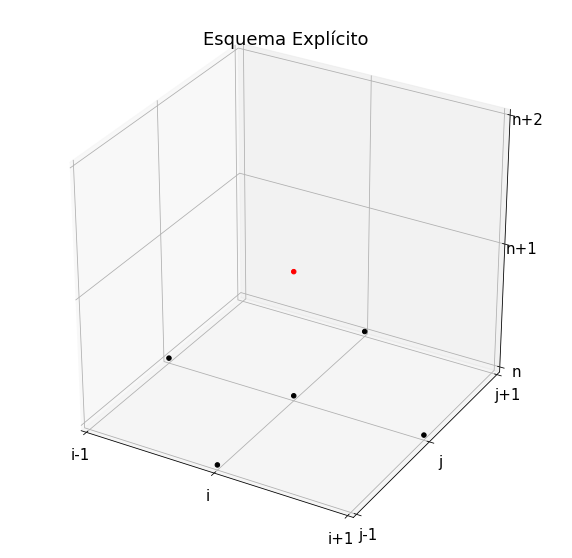

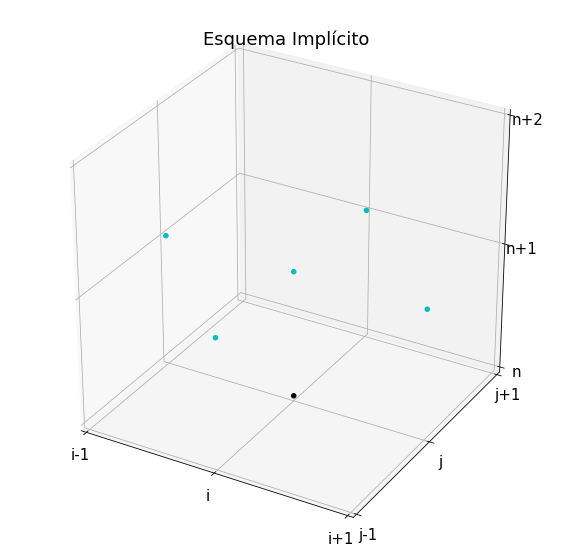

In [218]:
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
X = [0,1,1,2,1,1]
Y = [1,1,0,1,2,1]
Z = [0,0,0,0,0,1]
C = ['K','k','k','k','k','r']
ax.axis([0,2,0,2])
ax.set_zlim(0, 2)
ax.scatter(X,Y,Z, marker='o', s=20,c=C, alpha=1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.zaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticklabels(['i-1','i','i+1'])
ax.set_yticklabels(['j-1','j','j+1'])
ax.set_zticklabels(['n','n+1','n+2'])
plt.rcParams.update({'font.size': 15})
plt.title('Esquema Explícito')

fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111, projection='3d')
X = [1,0,1,2,1,1]
Y = [1,1,0,1,2,1]
Z = [0,1,1,1,1,1]
C = ['k','c','c','c','c','c']
ax.axis([0,2,0,2])
ax.set_zlim(0, 2)
ax.scatter(X,Y,Z, marker='o', s=20,c=C, alpha=1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.zaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticklabels(['i-1','i','i+1'])
ax.set_yticklabels(['j-1','j','j+1'])
ax.set_zticklabels(['n','n+1','n+2'])
plt.rcParams.update({'font.size': 15})
plt.title('Esquema Implícito')

2. Modifique el código desarrollado en la pregunta 3 de la sección anterior para que reconstruya la imagen usando un esquema implícito. 

In [354]:
'''
Input:
image - (array) matrix form of image
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
alpha - (float) A fixed value for initial condition
sigmax - (float) Fist difussion coefficient
sigmay - (float) Second difussion coefficient
dt - (float) time step
Output:
newImage - (array) matrix form of reconstructed image
'''
def fillHoleImplicit(image, start, width, lenght, alpha, sigmax, sigmay, dt):
    newImage=np.copy(image)
    dx = 1/(width+1)
    dy = 1/(lenght+1)
    a = sigmax*dt/dx**2
    b = sigmay*dt/dy**2
    
    A = np.zeros([(width+2)*(lenght+2), (width+2)*(lenght+2)])
    B = np.zeros([(width+2)*(lenght+2),1])
    bordes = B.copy()
    Breal= B.copy()
    
    for i in range(start[0],start[0]+lenght):
        for k in range(start[1],start[1]+width):
            newImage[i][k] = alpha
            
    for i in range(width+2):
        for k in range(lenght+2):
            j = k+i*(lenght+2)
            B[j] = newImage[start[1]-1+k][start[0]-1+i]
            Breal[j] = img[start[1]-1+k][start[0]-1+i]
            if i == 0 or i == width+1 or k == 0 or k == lenght+1:
                bordes[j] = newImage[start[1]-1+k][start[0]-1+i]

    for j in range((width+2)*(lenght+2)):
        if(bordes[j] == 0):
            i = j%(lenght+2)
            k = int(j/(lenght+2))
            A[j][i+1+(k*(lenght+2))] = -b 
            A[j][i-1+(k*(lenght+2))] = -b 
            A[j][i+(k+1)*(lenght+2)] = -a 
            A[j][i+(k-1)*(lenght+2)] = -a 
            A[j][j] = 1 + 2*sigmax*dt/dx**2 + 2*sigmay*dt/dy**2
        else:
            A[j][j] = 1
    
    i = 0
    tolx = 1e-06
    toly = 1e-09
    while True:
        auxB = B.copy()
       
        B = np.linalg.solve(A, B)
        diff = np.linalg.norm(B - auxB)
        i+=1
        if np.allclose(auxB, B, tolx, toly):
            print("Itera ", i)
            break
    k = 0   
    for i in range(start[0],start[0]+lenght):
        for j in range(start[1],start[1]+width):
            newImage[i][j] = B[k]
            k+=1 
    return newImage

3. Utilice la *Normal de Frobenius* para medir el error entre la imagen con *inpainting* y la imagen original. Mida el error para distintos *timestep*. Concluya en función de los resultados y en comparación con el uso de un método explícito.

In [356]:
start,width,length = findHole(img_nan)

sigmax = 0.1
sigmay = 0.1
alpha = 0
dt = [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]

for i in range(10):
    imgi = fillHoleImplicit(img_nan, start, width, length, alpha, sigmax, sigmay, dt[i])
    print("Error de: " + str(np.linalg.norm(img-imgi,ord='fro')))    

334
500
(100, 100)
10
25
Itera  71
Error de: 1.3024797
Itera  532
Error de: 1.3023517
Itera  4099
Error de: 1.3010806
Itera  29264
Error de: 1.2888018
Itera  177752
Error de: 1.2080384
Itera  787151
Error de: 2.2001188


KeyboardInterrupt: 

El error iba mejorando, hasta que se utilizo un dt muy bajo, por lo que debe de haber una curva de optimizacion para el dt.
En comparacion con el metodo anterior se mantiene el arror, pero las iteraziones aumentan.

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

---

# Referencias
https://www.geeksforgeeks.org/numpy-allclose-in-python/
https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html
https://www.geeksforgeeks.org/numpy-allclose-in-python/